# 3D parameter estimation using MCMC

Leverages the data produced in `drifter_3D.ipynb`

In [1]:
import os
from tqdm import tqdm

import xarray as xr
import pandas as pd
import numpy as np
np.random.seed(1234)

from scipy import stats

import matplotlib.pyplot as plt

#from gptide import stats as gpstats
import corner
import arviz as az

import nwatools.stats as st
#cm2in = .393701
c_dr = "#377eb8"
c_mo = "#ff7f00"

#data_dir = "data/"
#data_dir = "/home1/scratch/aponte/"
data_dir = "/home/datawork-lops-osi/aponte/nwa/drifter_stats"

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


/home1/datawork/aponte/code/pynsitu/pynsitu/__init__.py:46: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  hour = Timedelta("1H")
ERROR 1: PROJ: proj_create_from_database: Open of /home1/datawork/aponte/miniconda3/envs/equinox/share/proj failed


## Define kernels

In [2]:
case = "matern32_iso_matern12_pp_r0.0_u0.1"

uv = True # True if u and v are observed
parameter_eta_formulation = False # eta vs gamma formulation
noise = 0.01 # observation noise added to u/v
no_time = False # activates time inference
no_space = False # activates time inference
traj_decorrelation = False  # artificially decorrelate different moorings/drifters
#traj_decorrelation = True  # artificially decorrelate different moorings/drifters
if no_space:
    # makes little sense otherwise
    parameter_eta_formulation = True
    traj_decorrelation = True
assert not no_time, "need to implement decorrelation across time"

# run inference and store
#production = True
production = False
emcee = False

# inference number of platforms
Nxy = 8

In [3]:
# load drifters data
dsd = xr.open_dataset(os.path.join(data_dir, f"3D_{case}_drifters_selection.nc"))
dsd_full = (xr
    .open_dataset(os.path.join(data_dir, f"3D_{case}_drifters.nc"))
    .rename(lon="x", lat="y")
    .drop_vars("z")
)
_t = (dsd_full["time"] - dsd_full["time"][0,0]).median("traj",skipna=True)/pd.Timedelta("1D")
dsd_full = dsd_full.assign_coords(t=_t)
dsd_full["x"] = dsd_full["x"]/1e3
dsd_full["y"] = dsd_full["y"]/1e3

# load eulerian flow
dsf = xr.open_dataset(os.path.join(data_dir, f"3D_{case}_flow_selection.nc")).sortby("trajectory")
dsf["time"] = dsf["time"]/pd.Timedelta("1D")
ds_flow = xr.open_dataset(os.path.join(data_dir, f"3D_{case}_flow.zarr"))
ds_flow_reduced = ds_flow.sel(x=dsf.x, y=dsf.y).compute()

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [5]:
# problem parameters (need to be consistent with data generation notebook)

p = dsd.attrs
# !! to adjust
η = p["amplitude0"]  # streamfunction unit
#η = p["amplitude1"]  # potential unit
#
λx = p["lambda_x"]   # km
λy = p["lambda_y"]   # km
λt = p["lambda_t"]   # days

# derived velocity parameter
γ = η / λx 

Lx = float(ds_flow.x.max()-ds_flow.x.min())
Ly = float(ds_flow.y.max()-ds_flow.y.min())
# km, km this should not matter

In [6]:
# get 1D covariances
C, Ct, isotropy = st.get_cov_1D(p["cov_x"], p["cov_t"])
Cu, Cv, Cuv = C

/home1/datawork/aponte/code/nwa/nwatools/stats.py:155: RuntimeWarning: invalid value encountered in divide
  + x**2 * matern32_d1(d, 1., λ) / d
/home1/datawork/aponte/code/nwa/nwatools/stats.py:162: RuntimeWarning: invalid value encountered in divide
  + y**2 * matern32_d1(d, 1., λ) / d
/home1/datawork/aponte/code/nwa/nwatools/stats.py:169: RuntimeWarning: invalid value encountered in divide
  - matern32_d1(d, 1., λ) / d


Text(0.5, 1.0, 'uv covariance')

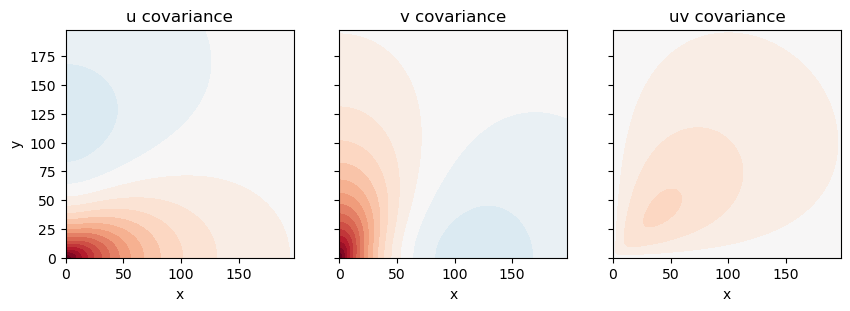

In [7]:
### inspect covariance

Nx, dx = 100, 2.  # km
Ny, dy = 100, 2.  # km
#Nt, dt = 100*24, 1/24  # days

t_x = np.arange(Nx)[:, None]*dx
t_y = np.arange(Ny)[:, None]*dy
#t_t = np.arange(Nt)[:, None]*dt

t_x2 = t_x   + t_y.T*0
t_y2 = t_x*0 + t_y.T  
t_d2 = np.sqrt(t_x2**2+t_y2**2)

Cov = xr.Dataset(
    dict(
        u=(("x", "y"), Cu(t_x2, t_y2, t_d2, λx)),
        v=(("x", "y"), Cv(t_x2, t_y2, t_d2, λx)),
        uv=(("x", "y"), Cuv(t_x2, t_y2, t_d2, λx)),
    ), 
                 
    coords=dict(x=("x", t_x[:,0]), y=("y", t_y[:,0]),),
)

cmax = max(
    float(np.abs(Cov.u).max()), 
    float(np.abs(Cov.v).max())
)
kwargs = dict(
    x="x", levels=30, vmax=cmax, vmin=-cmax, cmap="RdBu_r", add_colorbar=False,
)

fig, axes = plt.subplots(1,3, figsize=(10,5), sharey=True)
ax = axes[0]
Cov.u.plot.contourf(ax=ax, **kwargs)
ax.set_aspect("equal")
ax.set_title("u covariance")

ax = axes[1]
Cov.v.plot.contourf(ax=ax, **kwargs)
ax.set_aspect("equal")
ax.set_ylabel("")
ax.set_title("v covariance")

ax = axes[2]
Cov.uv.plot.contourf(ax=ax, **kwargs)
ax.set_aspect("equal")
ax.set_ylabel("")
ax.set_title("uv covariance")

#ax.set_title("u Covariance")


---

## utils

In [8]:
# common utils

def print_MAP(ds):
    
    MAP = ds.MAP.values

    print('noise (true): {:3.2f},  noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
    if parameter_eta_formulation:
        print('η   (true):   {:3.2f},  η     (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
    else:
        print('γ   (true):   {:3.2f},  γ     (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
    print('λx (true):   {:3.2f},   λx   (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))
    if not isotropy:
        print('λy (true):   {:3.2f},   λy   (mcmc): {:3.2f}'.format(covparams[2],  MAP[3])) 
    if not no_time:
        print('λt (true):   {:3.2f},   λt   (mcmc): {:3.2f}'.format(covparams[-1],  MAP[-1]))     
        
def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

def plot_inference(ds, xlim=True, subsample=None):

    if subsample is not None:
        ds = ds.assign_coords(i=ds["i"])
        ds = ds.isel(i=slice(0,None,subsample))
    samples = ds.samples.values
    samples_az = convert_to_az(samples, labels)
    
    density_data = [samples_az[labels],]
    density_labels = ['posterior',]
    if "priors" in ds:
        priors_out_az = convert_to_az(ds["priors"].values, labels)
        density_data += [priors_out_az[labels]]
        density_labels += ["prior"]
    
    axs = az.plot_density(   density_data,
                             shade=0.1,
                             grid=(1, 5),
                             textsize=12,
                             figsize=(12,3),
                             data_labels=tuple(density_labels),
                             hdi_prob=0.995)

    i=0
    for t, m, ax in zip([noise,]+list(covparams), ds["MAP"], axs[0]):
        #print(t, ax)
        ax.axvline(t, color="k", ls="-", label="truth") # true value
        ax.axvline(m, color="cadetblue", ls="-", lw=4, label="MAP") # MAP
        if isinstance(xlim, tuple):
            ax.set_xlim(*xlim)
        elif xlim:
            ax.set_xlim(0, t*2)
        if i==0:
            ax.legend()
        i+=1 
        
    fig = corner.corner(samples, 
                        show_titles=True,
                        labels=labels,
                        plot_datapoints=True,
                        quantiles=None, #[0.16, 0.5, 0.84]
                        truths=[noise,]+list(covparams),
                       )
    axes = fig.get_axes()
    for i, m in enumerate(ds.MAP.values):
        # 1D pdf
        ax = axes[i+4*i]
        ax.axvline(m, color="orange", lw=2)
    for i0, m0 in enumerate(ds.MAP.values):
        for i1, m1 in enumerate(ds.MAP.values):
            if i0==i1:            
                # 1D pdf
                ax = axes[i0+4*i0]
                ax.axvline(m0, color="cadetblue", lw=1, label="truth") # trick !
                ax.axvline(m0, color="orange", lw=2, label="map")
                if i0==0:
                    ax.legend()
            elif i1>i0:
                # 2D pdf
                ax = axes[i0+4*i1]
                ax.scatter(m0, m1, s=100, color="orange", marker="*", zorder=10)
    return fig

    
def traceplots(ds, MAP=True, subsample=None):

    if subsample is not None:
        ds = ds.assign_coords(i=ds["i"])
        ds = ds.isel(i=slice(0,None,subsample))
    
    fig, axes = plt.subplots(2,2, sharex=True, figsize=(15,6))
    
    for v, ax in zip(ds["parameter"], axes.flatten()[:ds.parameter.size]):
        ds.samples.sel(parameter=v).plot(ax=ax)
        if MAP:
            ax.axvline(ds.attrs["i_MAP"], color="b", lw=2)
        ax.set_title(v.values)
        ax.set_ylabel("")
        #print(v.values)

    fig, ax = plt.subplots(1,1, figsize=(7.5,3))
    ds["log_prob"].plot(ax=ax)
    if MAP:
        ax.axvline(ds.attrs["i_MAP"], color="b", lw=2)
    ax.set_ylabel("")
    ax.set_title("log_prob")

In [9]:
# set covariance parameters - should be a copy of the code in st.prepare_inference
if no_time:
    if uv:
        covfunc = lambda x, xpr, params: kernel_2d_iso_uv(x, xpr, params, (Cu, Cv, Cuv))
    else:
        covfunc = lambda x, xpr, params: kernel_2d_iso_u(x, xpr, params, Cu)
    covparams = [η, λx]
    labels = ['σ','η','λx',]
elif no_space:
    if uv:
        if traj_decorrelation:
            covfunc = lambda x, xpr, params: kernel_1d_uv_traj(x, xpr, params, (Cu, Cv, Cuv, Ct))
        else:
            covfunc = lambda x, xpr, params: kernel_1d_uv(x, xpr, params, (Cu, Cv, Cuv, Ct))
    else:
        assert False, "not implemented"
    covparams = [η, λx, λt]
    labels = ['σ','η','λx','λt']
elif isotropy:
    if uv:
        if parameter_eta_formulation:
            covfunc = lambda x, xpr, params: kernel_3d_iso_uv(x, xpr, params, (Cu, Cv, Cuv, Ct))
            covparams = [η, λx, λt]
            labels = ['σ','η','λx','λt']
        else:
            def covfunc(x, xpr, params):
                # params contains (gamma=eta/ld, ld, lt) and needs to be converted to (eta, ld, lt)
                params = (params[0]*params[1], *params[1:])
                if traj_decorrelation:
                    return kernel_3d_iso_uv_traj(x, xpr, params, (Cu, Cv, Cuv, Ct))
                else:
                    return kernel_3d_iso_uv(x, xpr, params, (Cu, Cv, Cuv, Ct))
            covparams = [γ, λx, λt]
            labels = ['σ','γ','λx','λt']
    else:
        covfunc = lambda x, xpr, params: kernel_3d_iso_u(x, xpr, params, (Cu, Ct))
        covparams = [η, λx, λt]
        labels = ['σ','η','λx','λt']
else:
    covfunc = lambda x, xpr, params: kernel_3d(x, xpr, params, (Cx, Cy, Ct))
    covparams = [η, λx, λy, λt]
    labels = ['σ','η','λx','λy','λt']

---

## Inference: fixed points -  space/time

We now use the `gptide.mcmc` function do the parameter estimation. This uses the `emcee.EnsembleSampler` class.


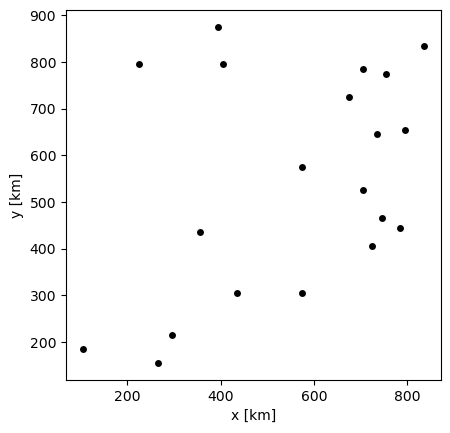

In [10]:
fig, ax = plt.subplots(1,1)
dsf.plot.scatter(x="x",y="y", c="k", ax=ax)
ax.set_aspect("equal")

In [11]:
# load data
ds = dsf
dt0 = float(np.unique(ds.time.diff("time"))[0])
print(f"initial time sampling rate {dt0:.3f} days")

initial time sampling rate 0.042 days


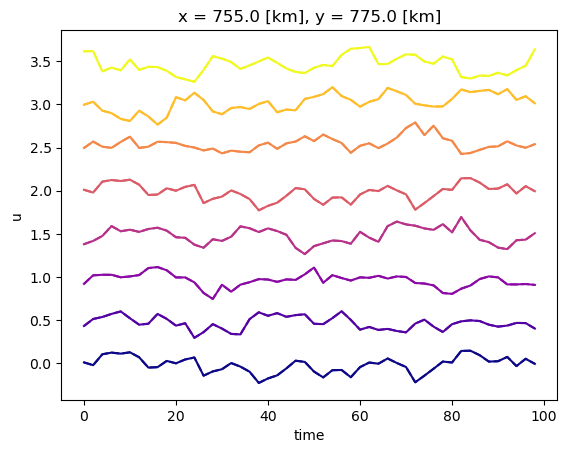

In [12]:
# decimate
if no_time:
    npts = 100
    dl = 200
    ds = (ds_flow
        .isel(time=0)
        .sel(x=slice(500-dl,500+dl), y=slice(500-dl,500+dl))
        .stack(trajectory=["x", "y"])
        .rename(U="u", V="v")
    )
    ds.u.unstack().plot()
    #
    narrow_selection = np.random.choice(ds.trajectory.values, npts)
    ds = ds.sel(trajectory=narrow_selection)
    #ds.unstack().psi.plot()
else:
    ds = ds.sel(time=slice(0, None, int(2/dt0)))   # temporally
    #ds = ds.isel(trajectory=slice(0, None, 2))    # spatially
    ds = ds.sel(trajectory=np.random.choice(ds.trajectory.values, Nxy))
    #
    #da = ds.u
    #da  = da + np.arange(ds.trajectory.size)/5
    #da.plot(hue="trajectory", add_legend=False, figsize=(5,7));
    col = plt.get_cmap('plasma')
    n = ds.trajectory.size
    for i, t in enumerate(ds.trajectory):
        (ds.sel(trajectory=t).u+i/2).plot(x="time", color=col(i/(n-1)))
        (ds.sel(trajectory=t).u+i/2).plot(x="time", color=col(i/(n-1)), ls="--")
    ax.set_title("u & v for a trajectory selection")    
    
# store for plotting purposes latter
ds_mo = ds

In [13]:
# number of data points
N = ds.u.size
assert Nxy==ds.trajectory.size, "issue with Nxy"
print(f"Number of data points = {N}, ({Nxy} spatial locations)")

# problem parameters (need to be consistent with data generation notebook)
if not no_time:
    Lt = float(ds.time.max()-ds.time.min()) # days

# estimate effective resolution
δx = Lx/Nxy
δy = Ly/Nxy
print("-- resolutions:")
print(f"λx/δx = {λx/δx}")
print(f"λy/δy = {λy/δy}")
if not no_time:
    δt = float(ds.time.diff("time")[0])
    print(f"λt/δt = {λt/δt}")

# estimate number of independent samples
print("-- independent samples (conservative):")
print(f"Lx/λx = {Lx/λx} ") # this is probably conservative
print(f"Ly/λy = {Ly/λy} ") # this is probably conservative
if not no_time:
    print(f"Lt/λt = {Lt/λt} ") # this is probably conservative

Number of data points = 400, (8 spatial locations)
-- resolutions:
λx/δx = 0.8080808080808081
λy/δy = 0.8080808080808081
λt/δt = 2.5000000000000004
-- independent samples (conservative):
Lx/λx = 9.9 
Ly/λy = 9.9 
Lt/λt = 19.6 


In [14]:
u, v, x, y, t = xr.broadcast(ds.u, ds.v, ds.x, ds.y, ds.time)
assert u.shape==v.shape==x.shape==y.shape==t.shape
x = x.values.ravel()
y = y.values.ravel()
t = t.values.ravel()
X = np.hstack([x[:,None], y[:,None], t[:,None]])
    
u = u.values.ravel()[:, None]
v = v.values.ravel()[:, None]

# add noise
u += np.random.randn(*u.shape)*noise
v += np.random.randn(*v.shape)*noise

if uv:
    X = np.vstack([X, X])
    U = np.vstack([u, v])
else:
    U = u

# dev
#X = X[::10,:]
#U = U[::10]
    
print(X.shape, U.shape)

(800, 3) (800, 1)


### emcee inference

In [15]:
if emcee:
    dsE0 = st.inference_emcee(X, U, noise, covparams, covfunc, labels)
    
    print_MAP(dsE0)
    plot_logprob(dsE0)
    plot_inference(dsE0)

### MH inference

In [ ]:
nc = os.path.join(data_dir, f"3D_{case}_moorings_reference_inference.nc")
if production:
    dsE1 = st.inference_MH(X, U, noise, covparams, covfunc, labels)
    # to control number of samples: ..., n_mcmc = int(10e3) ...
    dsE1.to_netcdf(nc, mode="w")
else:
    dsE1 = xr.open_dataset(nc)
# 5 min

In [ ]:
print_MAP(dsE1)
traceplots(dsE1)
plot_inference(dsE1)

---

## Inference: drifters - space/time

In [22]:
# load data
#ds = xr.open_dataset("data/drifters_3D_selection.nc", decode_times=False)
ds = dsd

dt0 = float(np.median(ds.time.diff("time")))
print(f"initial time sampling rate {dt0:.03f} days")

initial time sampling rate 0.042 days


In [23]:
# decimate
ds = (
    ds
    .isel(time=slice(0, -50, int(2/dt0)))   # temporally
    .sel(trajectory=np.random.choice(ds.trajectory.values, Nxy))
    #.isel(trajectory=slice(0, None, 2))    # spatially
)

# store for plotting purposes latter
ds_dr = ds

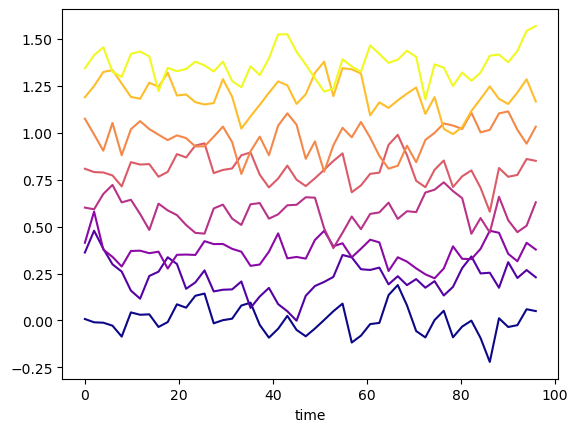

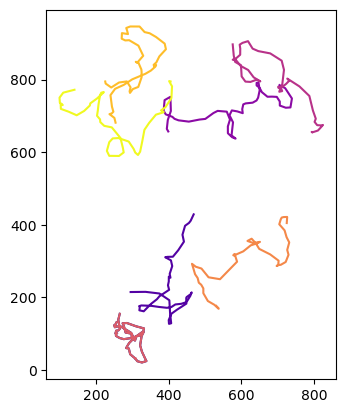

In [24]:
col = plt.get_cmap('plasma')
n = ds.trajectory.size

fig, ax = plt.subplots(1,1)
#da = ds.u
#da  = da + xr.ones_like(ds.trajectory).cumsum("trajectory")/5
for i, t in enumerate(ds.trajectory):
    _ds = ds.sel(trajectory=t)
    (_ds.u + t/5).plot(ax=ax, color=col(i/(n-1)))
    #da.plot(hue="trajectory", add_legend=False, figsize=(5,7));



fig, ax = plt.subplots(1,1)
for i, t in enumerate(ds.trajectory):
    _ds = ds.sel(trajectory=t)
    ax.plot(_ds.x, _ds.y, color=col(i/(n-1)))
    #(+i/2).plot(x="time", color=p(i/(n-1)))
    #(ds.sel(trajectory=t).u+i/2).plot(x="time", color=p(i/(n-1)), ls="--")
ax.set_aspect("equal")
#ax.set_title("u & v for a trajectory selection")    


#ax.scatter(ds.x, ds.y)
#for tr in ds.trajectory:
#    _ds = ds.sel(trajectory=tr)
#    ax.plot(_ds.x, _ds.y)
#    ds.scatter.plot("x", "y", hue="trajectory", ax=ax)
#ax.set_aspect("equal")

In [25]:
# number of data points
N = ds.u.size
Nxy = ds.trajectory.size
print(f"Number of data points = {N}, ({Nxy} drifters)")

# problem parameters (need to be consistent with data generation notebook)
Lt = float(ds.time.max()-ds.time.min()) # days

# estimate effective resolution
δx = Lx/Nxy
δy = Ly/Nxy
δt = float(ds.time.diff("time")[0])
print("-- resolutions:")
print(f"λx/δx = {λx/δx}")
print(f"λy/δy = {λy/δy}")
print(f"λt/δt = {λt/δt}")

# estimate number of independent samples
print("-- independent samples (conservative):")
print(f"Lx/λx = {Lx/λx} ") # this is probably conservative
print(f"Ly/λy = {Ly/λy} ") # this is probably conservative
print(f"Lt/λt = {Lt/λt} ") # this is probably conservative

Number of data points = 400, (8 drifters)
-- resolutions:
λx/δx = 0.8080808080808081
λy/δy = 0.8080808080808081
λt/δt = 2.5531914893617023
-- independent samples (conservative):
Lx/λx = 9.9 
Ly/λy = 9.9 
Lt/λt = 19.191666666666666 


In [26]:
# massage inputs to inference problem
u, v, x, y, t = xr.broadcast(ds.u, ds.v, ds.x, ds.y, ds.time)
assert u.shape==x.shape==y.shape==t.shape
x = x.values.ravel()
y = y.values.ravel()
t = t.values.ravel()

X = np.hstack([x[:,None], y[:,None], t[:,None]])

u = u.values.ravel()[:, None]
v = v.values.ravel()[:, None]

# add noise
u += np.random.randn(*u.shape)*noise
v += np.random.randn(*v.shape)*noise

if uv:
    X = np.vstack([X, X])
    U = np.vstack([u, v])
else:
    U = u

print(X.shape, U.shape)

(800, 3) (800, 1)


### emcee inference

In [27]:
if emcee:
    dsL0 = st.inference_emcee(X, U, noise, covparams, covfunc, labels)
    
    print_MAP(dsL0)
    traceplots(dsL0)
    plot_inference(dsL0)

### MH inference

In [28]:
nc = os.path.join(data_dir, f"3D_{case}_drifters_reference_inference.nc")
if production:
    dsL1 = st.inference_MH(X, U, noise, covparams, covfunc, labels)
    # to control number of samples: ..., n_mcmc = int(10e3) ...
    dsL1.to_netcdf(nc, mode="w")
else:
    dsL1 = xr.open_dataset(nc)

/home1/datawork/aponte/code/nwa/nwatools/stats.py:150: RuntimeWarning: invalid value encountered in divide
  + x**2 * matern32_d1(d, 1., λ) / d
/home1/datawork/aponte/code/nwa/nwatools/stats.py:164: RuntimeWarning: invalid value encountered in divide
  - matern32_d1(d, 1., λ) / d
/home1/datawork/aponte/code/nwa/nwatools/stats.py:157: RuntimeWarning: invalid value encountered in divide
  + y**2 * matern32_d1(d, 1., λ) / d
100%|██████████| 19999/19999 [36:04<00:00,  9.24it/s]

accepted fraction = 2.4 %


noise (true): 0.01,  noise (mcmc): 0.01
γ   (true):   0.06,  γ     (mcmc): 0.05
λx (true):   100.00,   λx   (mcmc): 148.24
λt (true):   5.00,   λt   (mcmc): 5.69


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


scp dunree:/home1/datawork/aponte/code/nwa/stats/figs/refcase_inference_corner.eps .
scp dunree:/home1/datawork/aponte/code/nwa/stats/figs/refcase_inference_corner.png .


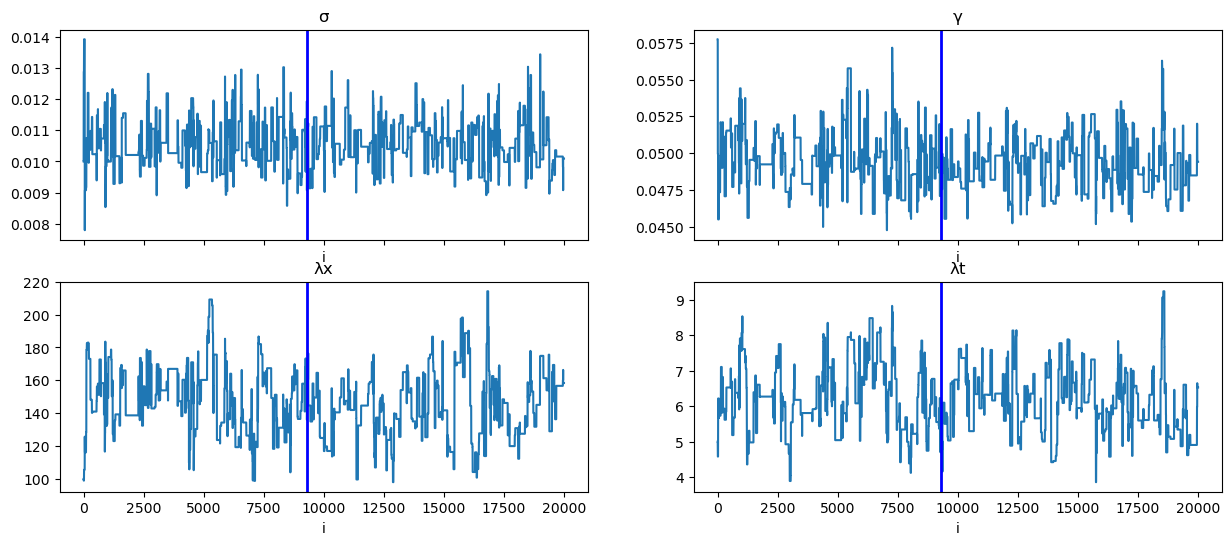

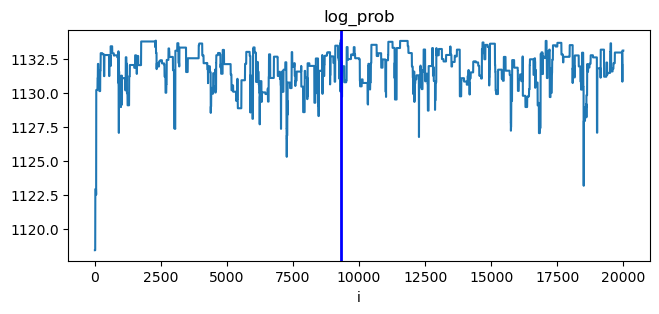

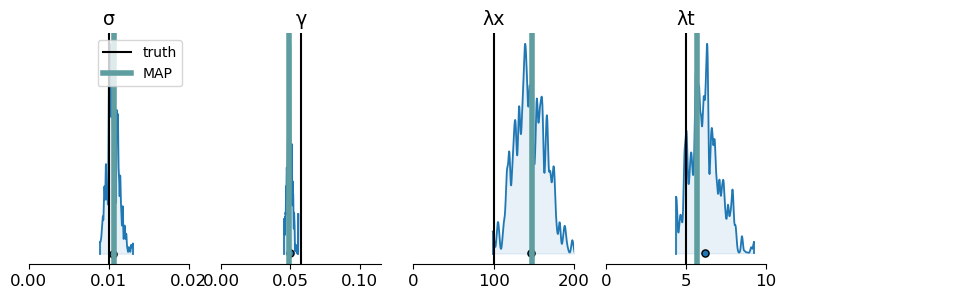

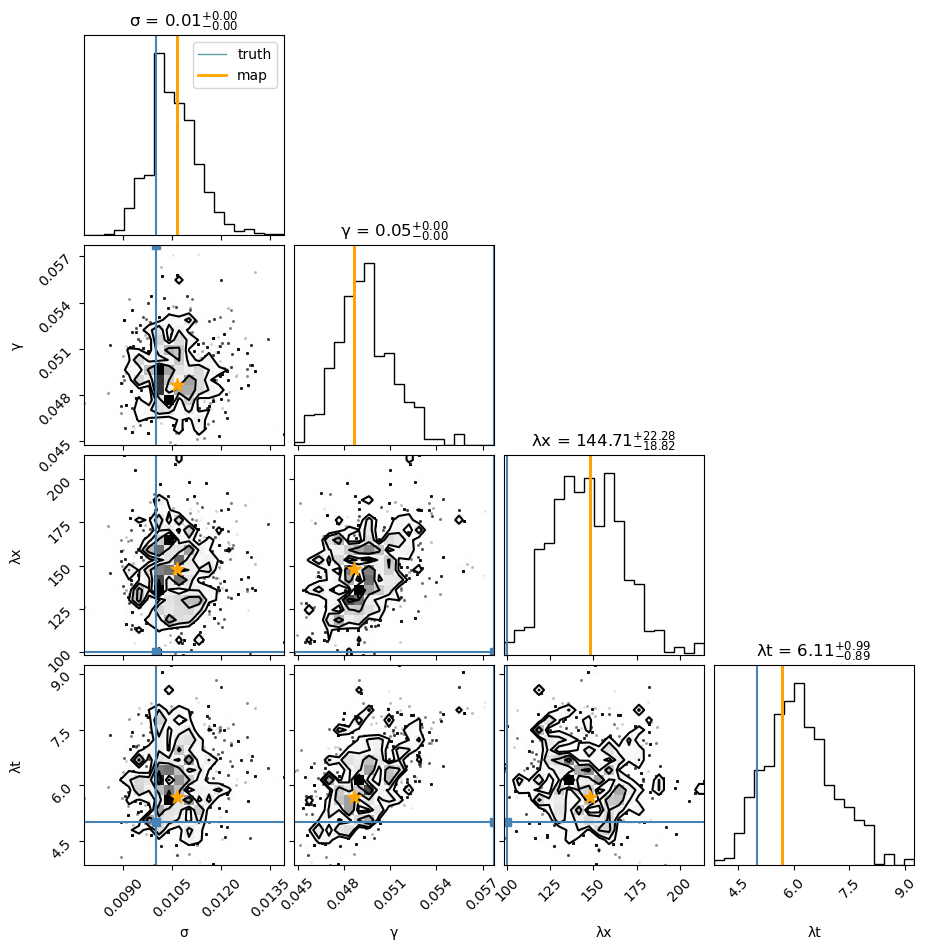

In [29]:
ds = dsL1
print_MAP(ds)
traceplots(ds) # , subsample=5

fig = plot_inference(ds)
label_and_print(fig, None, "refcase_inference_corner")

---

## reference case: data overview

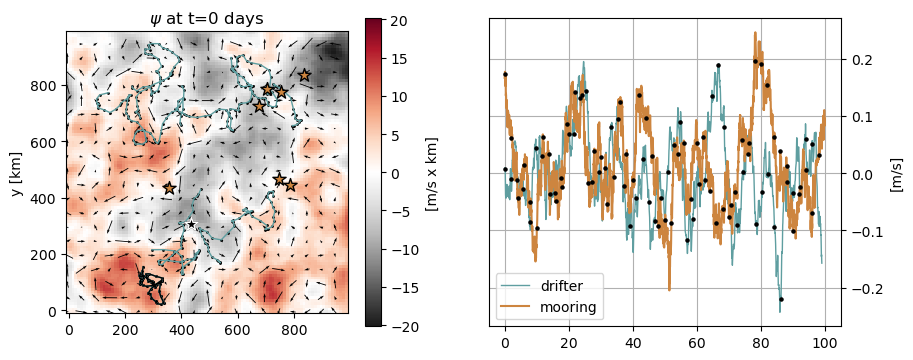

In [33]:
t=0
i_mo = 0
i_dr = 0
darrow = 5

# find index in full dataset
_dsf = ds_dr.isel(trajectory=i_dr).isel(time=0)
_ds = dsd_full.isel(obs=0)
i_dr_full = int(((_ds.x - _dsf.x)**2 + (_ds.y - _dsf.y)**2).argmin())

fig, axes = plt.subplots(1,2,figsize=(10,4))
#fig, axes = plt.subplots(1,2,figsize=(12*cm2in,5*cm2in))

# mooring observations
_dsmo = ds_mo.isel(trajectory=i_mo)
_dsmo_full = ds_flow.sel(x=_dsmo.x, y=_dsmo.y)
_dsmo_full["time"] = (_dsmo_full["time"]-_dsmo_full["time"][0])/pd.Timedelta("1D")
# mooring full data
# mooring full data
_dsf = ds_flow.copy()
_dsf["time"] = _dsf["time"]/pd.Timedelta("1D")
_dsf = _dsf.sel(time=t, method="nearest")
_dsa = _dsf.isel(x=slice(0,None,darrow), y=slice(0,None,darrow))

# drifter observations
_dsdr = ds_dr.isel(trajectory=i_mo)
# drifter full data
_dsdrf = dsd_full.isel(traj=i_dr_full)
_dsdrf["u"] =  _dsdrf["x"].differentiate("t") *1e3/86400

##
ax = axes[0]
_dsf.psi.plot(ax=ax, cmap="RdGy_r", cbar_kwargs={'label': "[m/s x km]"})
_dsa.plot.quiver("x", "y", "U", "V", ax=ax, add_guide = False)
# drifters
#ax.plot(dsd_full.x.T, dsd_full.y.T, color="cadetblue", lw=1)
ax.plot(ds_dr.x.T, ds_dr.y.T, color="cadetblue", lw=1)
#ax.plot(_dsdrf.x, _dsdrf.y, c="cadetblue",)
ax.scatter(ds_dr.x.T, ds_dr.y.T, c="k", s=1)
#ax.scatter(_dsdr.x, _dsdr.y, c="orange", s=.5, marker="o")
ax.plot(_dsdr.x, _dsdr.y, color="k", lw=1)
# moorings
ax.scatter(ds_mo.x, ds_mo.y, c="peru", s=100, marker="*", edgecolor="k", zorder=10)
ax.scatter(_dsmo.x, _dsmo.y, c="k", s=100, marker="*", edgecolor="w", zorder=10)
#
ax.set_aspect("equal")
ax.set_title(r"$\psi$ at t="+f"{_dsf.time.values:0.0f} days")
ax.set_xlabel("")

##
ax = axes[1]
# drifters
ax.plot(_dsdrf.t, _dsdrf.u, color="cadetblue", lw=1, label="drifter")
ax.scatter(_dsdr.time, _dsdr.u, c="k", s=5, zorder=10)
# moorings
ax.plot(_dsmo_full.time, _dsmo_full.U, color="peru", label="mooring")
ax.scatter(_dsmo.time, _dsmo.u, c="k", s=5, zorder=10)
#
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylabel("[m/s]")
ax.legend()
ax.grid()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


scp dunree:/home1/datawork/aponte/code/nwa/stats/figs/refcase_input_overview.eps .
scp dunree:/home1/datawork/aponte/code/nwa/stats/figs/refcase_input_overview.png .


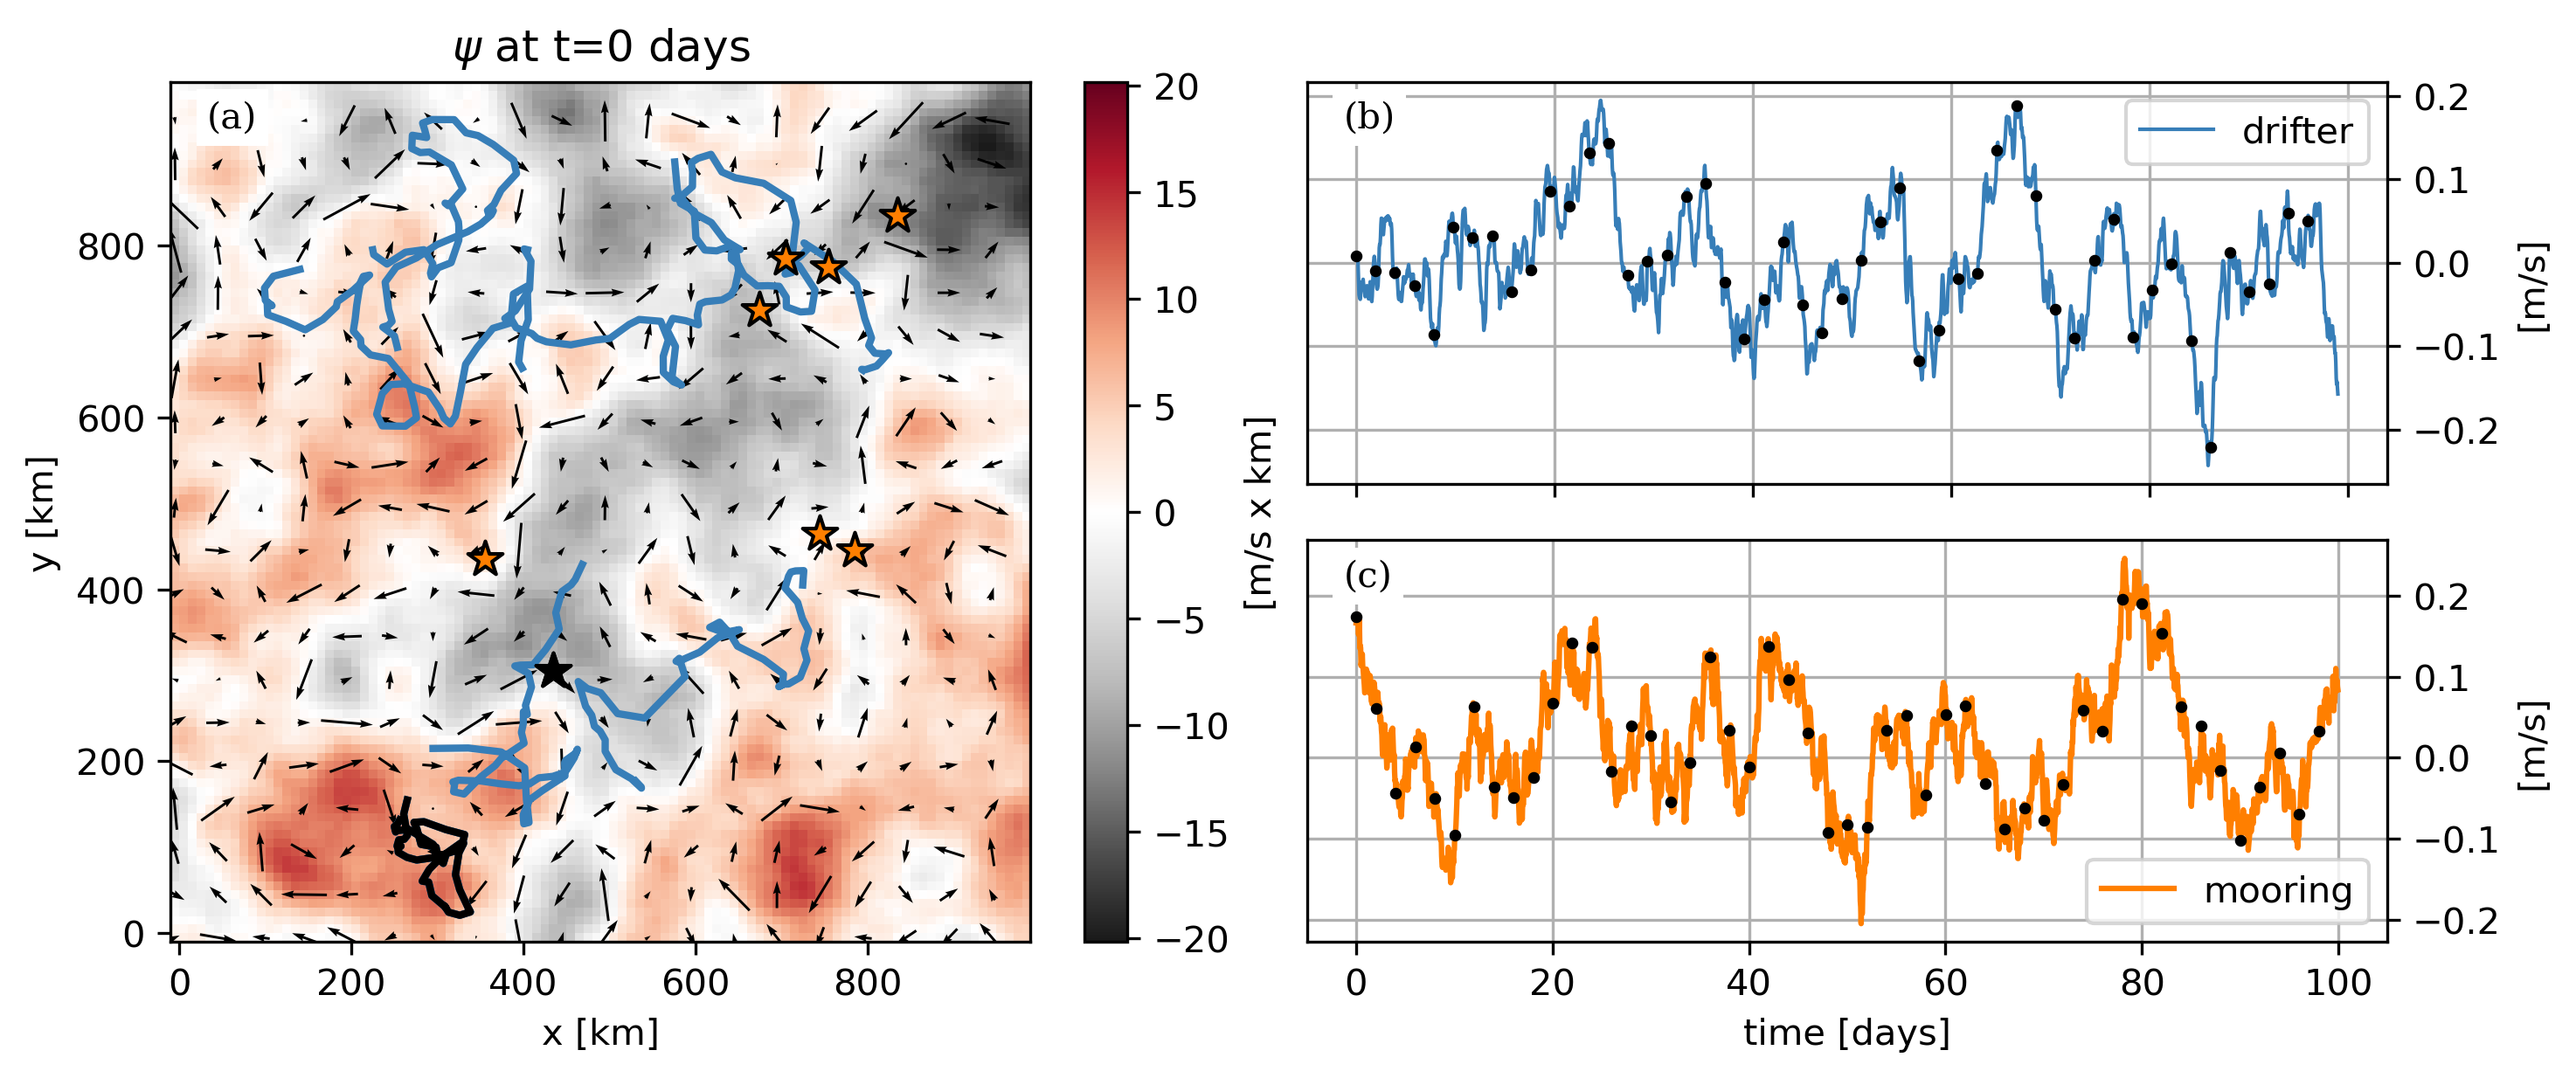

In [34]:
t=0
i_mo = 0
i_dr = 0
darrow = 5

# find index in full dataset
_dsf = ds_dr.isel(trajectory=i_dr).isel(time=0)
_ds = dsd_full.isel(obs=0)
i_dr_full = int(((_ds.x - _dsf.x)**2 + (_ds.y - _dsf.y)**2).argmin())

cmap = "RdGy_r"

fig, axs = plt.subplot_mosaic(
    [['(a)', '(b)'], ['(a)', '(c)']],
    layout='constrained',
    figsize=(10,4),
    dpi=300,
)

# mooring observations
_dsmo = ds_mo.isel(trajectory=i_mo)
_dsmo_full = ds_flow.sel(x=_dsmo.x, y=_dsmo.y)
_dsmo_full["time"] = (_dsmo_full["time"]-_dsmo_full["time"][0])/pd.Timedelta("1D")
# mooring full data
_dsf = ds_flow.copy()
_dsf["time"] = _dsf["time"]/pd.Timedelta("1D")
_dsf = _dsf.sel(time=t, method="nearest")
_dsa = _dsf.isel(x=slice(0,None,darrow), y=slice(0,None,darrow))

# drifter observations
_dsdr = ds_dr.isel(trajectory=i_mo)
# drifter full data
_dsdrf = dsd_full.isel(traj=i_dr_full)
_dsdrf["u"] =  _dsdrf["x"].differentiate("t") *1e3/86400

##
ax = axs["(a)"]

_dsf.psi.plot(ax=ax, cmap=cmap, cbar_kwargs={'label': "[m/s x km]"})
_dsa.plot.quiver("x", "y", "U", "V", ax=ax, add_guide = False)
# drifters
#ax.plot(dsd_full.x.T, dsd_full.y.T, color="cadetblue", lw=1)
ax.plot(ds_dr.x.T, ds_dr.y.T, color=c_dr, lw=2)
#ax.plot(_dsdrf.x, _dsdrf.y, c="cadetblue",)
#ax.scatter(ds_dr.x.T, ds_dr.y.T, c="k", s=1, zorder=10)
#ax.scatter(_dsdr.x, _dsdr.y, c="orange", s=.5, marker="o")
ax.plot(_dsdr.x, _dsdr.y, color="k", lw=2)
# moorings
ax.scatter(ds_mo.x, ds_mo.y, c=c_mo, s=100, marker="*", edgecolor="k", zorder=10)
ax.scatter(_dsmo.x, _dsmo.y, c="k", s=100, marker="*", edgecolor="k", zorder=10)
#
ax.set_aspect("equal")
ax.set_title(r"$\psi$ at t="+f"{_dsf.time.values:0.0f} days")
ax.set_xlabel("x [km]")

##
ax = axs["(b)"]

# drifters
ax.plot(_dsdrf.t, _dsdrf.u, color=c_dr, lw=1, label="drifter")
ax.scatter(_dsdr.time, _dsdr.u, c="k", s=5, zorder=10)
#
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylabel("[m/s]")
ax.legend()
ax.grid()
ax.set_xticklabels("")

##
ax = axs["(c)"]

# moorings
ax.plot(_dsmo_full.time, _dsmo_full.U, color=c_mo, label="mooring")
ax.scatter(_dsmo.time, _dsmo.u, c="k", s=5, zorder=10)
#
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylabel("[m/s]")
ax.legend()
ax.grid()
ax.set_xlabel("time [days]")

label_and_print(fig, axs, "refcase_input_overview")

---

# ! do not look passed this point

---

## Inference: drifters - time only: !! to be updated

In [104]:
# Initial guess of the noise and covariance parameters (these can matter)

_η = p["eta"] # need to recall velocity amplitude here, not streamfunction one

covfunc = kernel_1d
covparams = [_η, λt]
noise_prior      = gpstats.truncnorm(noise, noise*2, noise/10, noise*10)     # noise
covparams_priors = [gpstats.truncnorm(_η, _η*2, _η/10, _η*10),                   # eta
                    gpstats.truncnorm(λt, λt*2, λt/10, λt*10),               # λt
                   ]

In [105]:
# load data
ds = dsd

dt0 = float(np.median(ds.time.diff("time")))
print(f"initial time sampling rate {dt0} days")

# decimate
ds = ds.sel(time=slice(0, None, int(1/dt0)))   # temporally
#ds = ds.isel(trajectory=slice(0, None, 1))    # spatially

# select one drifter:
ds = ds.isel(trajectory=0)

ds

initial time sampling rate 0.04166666666666696 days


<xarray.Dataset>
Dimensions:  (time: 104)
Coordinates:
  * time     (time) float64 0.0 0.9583 1.917 2.875 ... 95.83 96.79 97.75 98.71
Data variables:
    y        (time) float32 ...
    x        (time) float32 ...
    u        (time) float64 -0.2382 -0.05576 0.07991 ... -0.2384 -0.2206 -0.1537
    v        (time) float64 0.216 0.1322 -0.107 ... 0.05221 0.003476 -0.045
Attributes: (12/17)
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.0
    parcels_mesh:           flat
    eta:                    0.2
    ...                     ...
    cov_t:                  matern12
    kind:                   pp
    amplitude0:             14.142135623730951
    amplitude1:             0.0
    alpha:                  0.0
    noise:                  0.0

In [106]:
# should estimate effective number of points ...

In [107]:
u, x, y, t = xr.broadcast(ds.u, ds.x, ds.y, ds.time)
assert u.shape==x.shape==y.shape==t.shape
x = x.values.ravel()
y = y.values.ravel()
t = t.values.ravel()

X = np.hstack([x[:,None], y[:,None], t[:,None]])
u = ds.u.values.ravel()[:, None]

# add noise
u += np.random.randn(*u.shape)*noise

print(X.shape, u.shape)

(104, 3) (104, 1)


In [108]:
samples, log_prob, priors_out, sampler = mcmc.mcmc(
    X,
    u,
    covfunc,
    covparams_priors,
    noise_prior,
    nwarmup=100,
    niter=100,
    verbose=False,
)

Running burn-in...


100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


Running production...


100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


In [109]:
i = np.argmax(log_prob)
MAP = samples[i, :]

print('noise (true): {:3.2f},  noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
print('η   (true):   {:3.2f},  η     (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
print('λt (true):   {:3.2f},   λt   (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))

noise (true): 0.01,  noise (mcmc): 0.02
η   (true):   0.20,  η     (mcmc): 0.21
λt (true):   5.00,   λt   (mcmc): 1.84


In [ ]:
labels = ['σ', 'η', 'λt']

def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples, labels)

axs = az.plot_density(   [samples_az[labels], 
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 5),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)

for t, m, ax in zip([noise,]+list(covparams), MAP, axs[0]):
    print(t, ax)
    ax.axvline(t, color="k", ls="-")
    ax.axvline(m, color="b", ls="-")
    #ax.set_xlim(0, t*2)

In [ ]:
fig = corner.corner(samples, 
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])

### inference fixed-points ... to be done

---
### empirical spectra

In [52]:
import pynsitu as pin

In [11]:
Ed = dsd.ts.spectrum(method='periodogram', include=["u", "v"], detrend="linear")
Ef = dsf.ts.spectrum(method='periodogram', include=["u", "v"], detrend="linear")

In [12]:
#eta = float(dsd.u.std())
eta = η/λx
if p["cov_t"]=="matern12":
    nu = 1/2
elif p["cov_t"]=="matern32":
    nu = 3/2
E_input = cov.matern_spectra(Ed.frequency, eta, nu, λt)

In [13]:
# interpolate eulerian field on a finer timeline
#dsf_full_interp = dsf.resample(time="1H").interpolate()
#Ef_interp = dsf_full_interp.ts.spectrum(method='periodogram', include=["U", "V"], detrend="linear", unit="1D")

In [ ]:
fig, ax = plt.subplots(1,1)
#Ed.u.plot(hue="trajectory", add_legend=False, color="0.5", alpha=0.5)
E_inpst.plot(color="k", lw=3, label="input")
Ed.u.mean("trajectory").plot(add_legend=False, color="orange", lw=3, label="lagrangian")
Ef.u.mean("trajectory").plot(add_legend=False, color="cadetblue", lw=3, label="eulerian")
#Ef_interp.U.mean("trajectory").plot(add_legend=False, color="cadetblue", ls="-", lw=1, label="eulerian interpolated")
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xlim(None, 1e0)
ax.set_ylim(1e-10, 1e0)
ax.set_ylim(1e-7, 1e0)
ax.grid()
ax.legend()
ax.set_title("")

In [15]:
#dsf.u.plot(x="time", hue="trajectory")

### inspect absolute displacement distribution

In [17]:
from xhistogram.xarray import histogram

In [53]:
_dsd = dsd_full.sel(obs=slice(0,24*10,1))

_dsd["x_abs"] = _dsd["x"] - _dsd["x"].isel(obs=0)
_dsd["y_abs"] = _dsd["y"] - _dsd["y"].isel(obs=0)
_dsd["r_abs"] = np.sqrt(_dsd["x_abs"]**2 + _dsd["y_abs"]**2)
_dsd["dispersion_abs"] = (_dsd["r_abs"]**2).mean("traj")

In [ ]:
fig, ax = plt.subplots(1,1)
_dsd["dispersion_abs"].plot(x="t", lw=4, ax=ax)
ax.plot(_dsd.t)
ax.grid()
# add references

In [81]:
bins = np.arange(-100,100,2)
bins_positive = np.arange(0,400,2)

In [82]:
#r2 = ((_dsd.r_abs)**2).rename("r2") #.fillna(1e9)
#h2 = histogram(r2, bins=bins**2, dim=["traj"]).compute()

r = ((_dsd.r_abs)).rename("r") #.fillna(1e9)
pr = histogram(r, bins=bins_positive, dim=["traj"], density=True, keep_coords=True).compute()
pr = pr.rename("p").rename(r_bin="r")

In [ ]:
np.log10(pr/pr.r).plot()

In [ ]:
fig, ax = plt.subplots(1,1)

col = plt.get_cmap('plasma')
n = 10
for t in range(1,n):
    _p = pr.isel(obs=24*t)/pr.r
    _p.plot(color=col(t/(n-1)), label=f"t={_p.t:.1f}", lw=2)
    
#ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
#ax.set_ylabel("log(p)")
ax.set_title("p/r")

In [ ]:
N = histogram(_dsd.x_abs, _dsd.y_abs, bins=[bins, bins], dim=["traj"], density=True).compute()
p = N.rename("p").rename(x_abs_bin="x", y_abs_bin="y")
p.sel(obs=24*1).plot()